# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.15.0


In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Check GPU

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 24 19:59:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8               5W /  40W |      9MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## SP: Student Performance (Portuguese)

There is also a Math dataset

https://archive.ics.uci.edu/dataset/320/student+performance

For `y`, G3 is the final grade.

In [8]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 

In [9]:
X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,4
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,6
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,yes,yes,no,5,4,2,1,2,5,4
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,yes,yes,no,4,3,4,1,1,1,4
646,MS,F,18,U,GT3,T,1,1,other,other,...,yes,no,no,1,1,1,1,1,5,6
647,MS,M,17,U,LE3,T,3,1,services,services,...,yes,yes,no,2,4,5,3,4,2,6


In [19]:
categorical_columns = X.select_dtypes(include=['object']).columns  # Columnas categóricas (string)
numerical_columns = X.select_dtypes(exclude=['object']).columns    # Columnas numéricas

In [20]:
categorical_columns

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [21]:
numerical_columns

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')

In [22]:
# Aplicamos get_dummies solo a las columnas categóricas
X_dummies = pd.get_dummies(X[categorical_columns], drop_first=True)

# Concatenamos las columnas numéricas con las columnas dummificadas
X_final = pd.concat([X[numerical_columns], X_dummies], axis=1)

# Convertimos el DataFrame final a un array de NumPy
X = X_final.values

# Imprimir para verificar la salida
print(X)

[[18  4  4 ...  1  0  0]
 [17  1  1 ...  1  1  0]
 [15  1  1 ...  1  1  0]
 ...
 [18  1  1 ...  1  0  0]
 [17  3  1 ...  1  1  0]
 [18  3  2 ...  1  1  0]]


In [17]:
y = np.asarray(y['G3'])

In [24]:
y = y.reshape(-1, 1)

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [25]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (454, 39)
Test set size: (195, 39)
Training features size: (454, 39)
Training labels size: (454,)


## Defining KQM-Model

In [26]:
n_comp=32

In [27]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(39,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

2024-10-24 20:08:36.193590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-24 20:08:36.193785: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-24 20:08:36.193863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

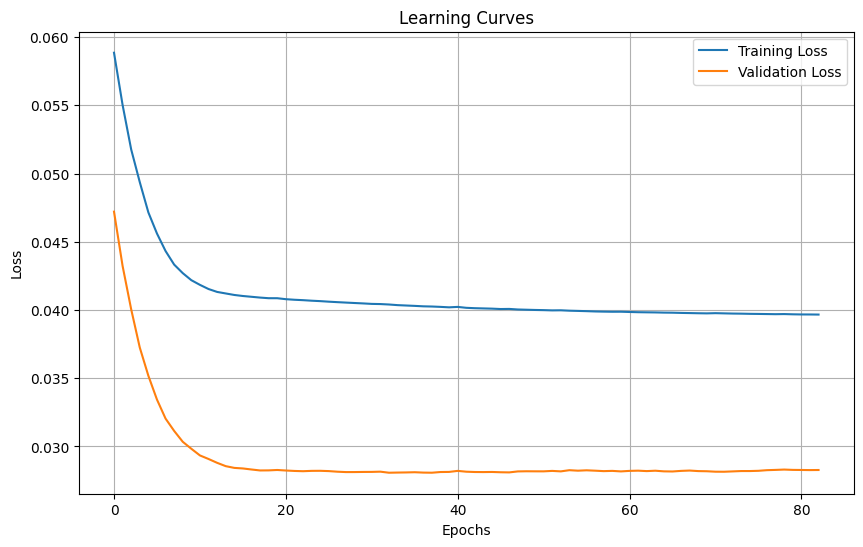

MAE = 2.451022813259027
MSE = 11.148250031078327
R^2 = -0.00814820810146677


In [28]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 39
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


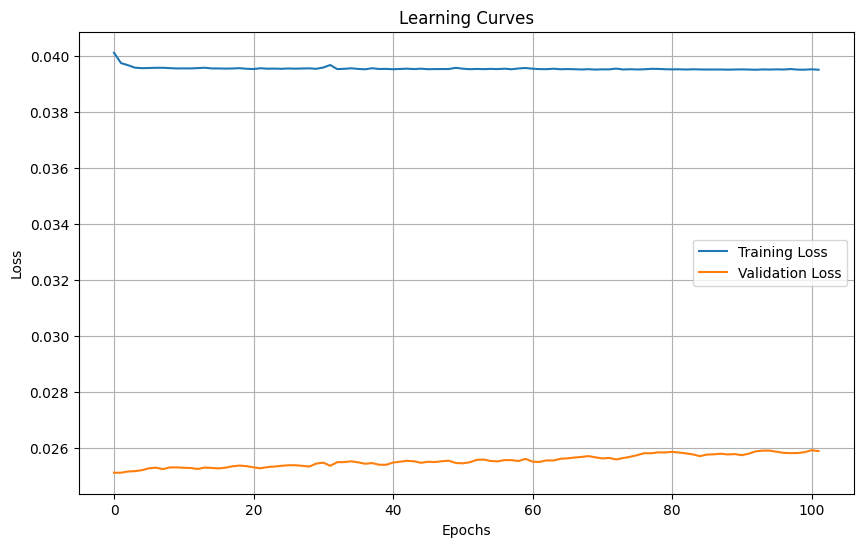

MAE = 2.437733092674842
MSE = 11.084969486855282
R^2 = -0.0024256806116544904


In [29]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 39
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [30]:
y_pred

array([11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 11.928529, 11.928529,
       11.928529, 11.928529, 11.928529, 11.928529, 

In [31]:
y_test

array([19, 12, 18, 11, 11, 17, 18,  8, 10, 11, 18, 11, 12,  9, 12, 14, 13,
        8, 15, 14, 15, 13, 13, 13, 16, 13,  8, 12, 10, 15, 16, 12,  9,  8,
       18, 16, 14, 15, 14, 11, 13, 10,  8, 11, 14, 12, 18, 12, 14, 12, 10,
       11, 14, 11, 11, 18, 10, 11, 11, 10, 10, 11, 16, 14, 17, 15, 11, 10,
        0, 10, 16, 15, 12, 16, 13, 12, 13, 15, 13, 14, 11, 12, 17,  8, 12,
       17, 11,  9, 15, 13, 14,  9, 11, 18,  9, 15, 16, 10, 12, 10, 12, 11,
       10, 11, 13, 10, 11, 11, 10, 13, 13, 11, 11, 10,  8, 11, 11, 16, 16,
       10, 14,  0, 15, 14, 12,  7, 17, 11, 12, 10, 18, 12, 12, 13, 10, 11,
        9, 10,  0, 12, 11, 12, 12, 11, 11,  8, 13, 13, 16, 12, 16, 10,  6,
       15, 13,  9, 12, 17, 11, 13, 13, 17, 10, 11, 10, 15, 14,  9,  0, 12,
       13, 14, 14, 13,  7, 10, 18, 10,  0, 13, 15, 16, 17, 11, 10, 11, 16,
        9, 14, 11, 10,  8, 11, 10, 12])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [32]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = 39
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [33]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(39,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [34]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 3.0030400545169145
MSE = 15.54166525680303
R^2 = -0.40544945941109867
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 2.9668552692119894
MSE = 15.273561378057229
R^2 = -0.3812045380836129
New best model
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 2.5035830913445887
MSE = 11.763087282130861
R^2 = -0.06374860019840378
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 2.467745648897611
MSE = 11.329290571207764
R^2 = -0.024519898332346912
New best model
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 2.459815846956693
MSE = 11.210571937508245
R^2 = -0.01378404494739649
New best model
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 2.395315238757011
MSE = 10.792841501002439
R^2 = 0.023991766490161992
New best model
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 2.4503874118511493
MSE = 11.14

```
Running experiment with learning_rate=0.01 and kernel=cos
MAE = 2.4794610769320755
MSE = 10.410757134858466
R^2 = 0.05854406555035563
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [41]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [128, 256, 512]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [42]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(39,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [43]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=128 and num_h_l=1
MAE = 2.9817587290054712
MSE = 15.409745251234652
R^2 = -0.39351979180804486
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=128 and num_h_l=2
MAE = 2.982240134019118
MSE = 15.414146941102226
R^2 = -0.39391784134409247
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=256 and num_h_l=1
MAE = 2.9826867176936225
MSE = 15.418232234180412
R^2 = -0.39428727877910363
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=256 and num_h_l=2
MAE = 2.9826653896233974
MSE = 15.418037084050667
R^2 = -0.3942696311435496
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=512 and num_h_l=1
MAE = 2.9817208607991534
MSE = 15.409399100588184
R^2 = -0.3934884890337982
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=512 and num_h_l=2
MAE = 2.982239698752379
MSE = 15.414142960269144
R^2 = -0.39

```
Running experiment with learning_rate=0.001, kernel=cos, encoding_dim=128 and num_h_l=2
MAE = 2.0989917021531324
MSE = 7.833066155530644
R^2 = 0.29164742568348834
New best model

Running experiment with learning_rate=0.0001, kernel=cos, encoding_dim=256 and num_h_l=2
MAE = 2.136703946040227
MSE = 7.833904401570936
R^2 = 0.2915716221949487
New best model
```

So, an encoder does improves the performance in this case.

In [44]:
y_test.max(), y_test.mean(), y_test.min()

(19, 12.092307692307692, 0)